# The simplest (maybe) closed-loop example for metabolomics

In [257]:
import numpy as np
import copy

The problem setup (note from Simon: I appreciate that this is long-winded, but I think the description can be shortened)

- We've measured a set of objects, each of which is characterised by time. For a subet of these objects we have also measured some additional information by which they can be uniquely identified (fragments in metabolomics jargon)
- We then measure a second set of objects, some of which will match those in set 1 (some in set 1 will be in set 2, some in set 2 will be in set 1, some will be unique to one set or the other)
- In set 2 there is a time drift with respect to set 1.
- Our goal (at least initially) is to infer this drift
- We can learn the drift using points that we can match (based upon the additional information described above). But there is a cost associated with these additional measurements and we can make only a limited number of them
- When we make such a measurement it will tell us that either:
    - the point we measure is the same as one of the ones in set 1 for which the additional information is available, or...
    - it is not the same as any for which additional information is available
    
Note: in reality, the problem is more constrained as we have to make the additional measurements in time order...

Initial cell to sample some _true_ times for `N` examples.

We then choose `n_data` examples for each of sets 1 and 2

In [258]:
N = 30
true_vals = np.random.rand(N)
true_vals.sort()
print(true_vals)
n_data = 25 # how many to pick in each dataset
data_1 = []
data_1_idx = np.random.permutation(range(N))[:n_data]
data_2_idx = np.random.permutation(range(N))[:n_data]
data_1_idx.sort()
data_2_idx.sort()

opt = len(set(data_1_idx).intersection(set(data_2_idx)))
print("Overlap size = {}".format(opt))

[0.0059292  0.04830485 0.06381327 0.10907515 0.11892275 0.13234446
 0.15741962 0.17692671 0.18487758 0.23824981 0.32298318 0.36494721
 0.36970037 0.46171805 0.51219373 0.54798402 0.60112424 0.63555845
 0.7285889  0.75920158 0.77040546 0.79786593 0.81582531 0.82522375
 0.87289357 0.88469241 0.88741693 0.89780904 0.91492281 0.96649594]
Overlap size = 20


We now decide which of the data in set 1 has the additioonal information available. Here it is randomly assigned with probability `frag_prob_1`.

In [259]:
frag_prob_1 = 0.7
frag_1 = []
for i in range(n_data):
    if np.random.rand() <= frag_prob_1:
        frag_1.append(1)
    else:
        frag_1.append(0)
    

Next step is sampling a true offset function for set 2 from a GP

Text(0, 0.5, 'time offset')

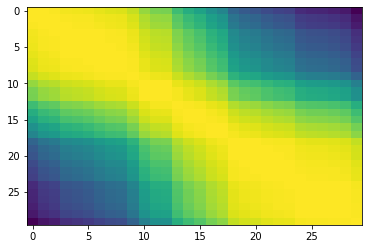

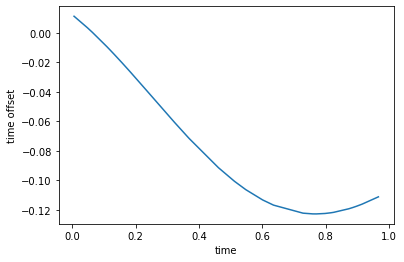

In [260]:
# sample an offset function
alpha = 0.01
gam = 1.
K = np.zeros((N,N),np.double)
for n in range(N):
    for m in range(N):
        K[n,m] = alpha*np.exp(-(1./gam)*(true_vals[n]-true_vals[m])**2)
        
import pylab as plt
%matplotlib inline
plt.imshow(K,aspect='auto')
true_offset_function = np.random.multivariate_normal(np.zeros(N),K)
plt.figure()
plt.plot(true_vals,true_offset_function)
plt.xlabel('time')
plt.ylabel('time offset')

Now we make the observed data. In the case of set 1 this is identical to the originals. For set 2, it is a noisy realisation of the original plus the offset function

In [261]:
noise_ss = 0.00000
observed_1 = true_vals[data_1_idx]
observed_2 = true_vals[data_2_idx] + true_offset_function[data_2_idx] + np.random.normal(n_data)*np.sqrt(noise_ss)
main_K = np.zeros((n_data,n_data),np.double)
for n in range(n_data):
    for m in range(n_data):
        main_K[n,m] = alpha*np.exp((-1./gam)*(observed_2[n] - observed_2[m])**2)

A method to find the closest matching point in set 2 to the points in set 1.

Any confirmed match (stored in `confirmed_matches`) will be added to the match set and the objects invovled cannot be added to anything else

In [272]:
def closest_match(peaks1,peaks2,confirmed_matches,queried_points,frag_1,max_rt = 0.1,predictions = None):
    matches = copy.deepcopy(confirmed_matches)
    if len(matches) > 0:
        used1,used2 = zip(*matches)
        used1 = set(used1)
        used2 = set(used2)
    else:
        used1 = set()
        used2 = set()
    for i,r in enumerate(peaks2):
        
        r2 = r
        if predictions is not None:
            r2 += predictions[i]
        
        if i in used2: # if this one is in one of the confirmed matches, we don't need to deal with it
            continue 
        else:
            # compute all distances
            pi = list(zip(peaks1,range(len(peaks1)),[abs(p-r2) for p in peaks1]))
            # keep only those below the max time shift for matching
            pi = list(filter(lambda x: x[2] <= max_rt,pi))
            # find the closest that is not already used .... and
            # if the set 2 point (i) has been queried before then if we get to here it wasn't matched
            # so it cannot be matched against something for which we have the additional info
            closest_dist = 1e6
            best_pos = -1
            for idx,_ in enumerate(pi):
                if pi[idx][1] not in used1 and pi[idx][2] <= closest_dist and not (i in queried_points and frag_1[idx] == 1):
                    best_pos = idx
                    closest_dist = pi[idx][2]
            if best_pos > -1:
                matches.append((pi[best_pos][1],i))
                used1.add(pi[best_pos][1])
                used2.add(i)
                assert pi[best_pos][2] <= max_rt
    return matches
            

            

Method to visualise the status of the world

In [273]:
def plot_match(peaks1,peaks2,frag_1,matches,confirmed_matches,relative=True,predictions = None,truth=None):
    plt.figure()
    if not relative:
        plt.plot(peaks2,np.zeros_like(peaks2),'ro')
        plt.plot(np.zeros_like(peaks1),peaks1,'ro')
        p1 = []
        for i,f in enumerate(frag_1):
            if f == 1:
                p1.append(peaks1[i])
        plt.plot(np.zeros_like(p1),p1,'ko')

    for a,(i,j) in enumerate(matches):
        col = 'ro' # default
        if truth is not None:
            if truth[a] == 1:
                col = 'bo' # match is correct, so make it blue
        if (i,j) in confirmed_matches: # if this is a confirmed one
            if not relative:
                plt.plot(peaks2[j],peaks1[i],col,markersize=15)
            else: # plotting difference not absolute time
                plt.plot(peaks2[j],peaks1[i]-peaks2[j],col,markersize=15)
                if predictions is not None:
                    plt.plot(peaks2[j],predictions[j],'ko',markersize=3) # plot a point where the current model prediction is
                    plt.plot([peaks2[j],peaks2[j]],[predictions[j],peaks1[i]-peaks2[j]],'k',color=[0.8,0.8,0.8])
        else:
            if not relative:
                plt.plot(peaks2[j],peaks1[i],col)
            else:
                plt.plot(peaks2[j],peaks1[i]-peaks2[j],col)
                if not predictions is None:
                    plt.plot(peaks2[j],predictions[j],'ko',markersize=3)
                    plt.plot([peaks2[j],peaks2[j]],[predictions[j],peaks1[i]-peaks2[j]],'k',color=[0.8,0.8,0.8])




        if not relative:
            plt.plot([peaks2[j],peaks2[j]],[0,peaks1[i]],'k',color=[0.8,0.8,0.8])
            plt.plot([0,peaks2[j]],[peaks1[i],peaks1[i]],'k',color=[0.8,0.8,0.8])
    plt.xlim([0,1])
    if not relative:
        plt.ylim([0,1])

Method to assess whether or not matches are correct (helpful for plotting)

In [274]:
def assess_matches(matches,idx_1,idx_2):
    truth = []
    for i,j in matches:
        if idx_1[i] == idx_2[j]:
            truth.append(1)
        else:
            truth.append(0)
    return truth

Querying method. We are querying the point stored at index `pos` in set 2. If it matches something in set 1 the pair is returned. If not, None is returned

In [275]:
def query(data_1_idx,data_2_idx,pos,frag_1):
    idx = data_2_idx[pos]
    for i,ii in enumerate(data_1_idx):
        if ii == idx and frag_1[i] == 1:
            print("HIT")
            return (i,pos)
    return None

Method to fit the GP and compute the predicted offset function that can be used to correct the points in set 2

In [276]:
def fit_and_predict(peaks1,peaks2,confirmed_matches,main_K):
    d2_idx = []
    d1_idx = []
    for i,j in confirmed_matches:
        d2_idx.append(j)
        d1_idx.append(i)
    sub_K = main_K[d2_idx,:][:,d2_idx] + np.eye(len(d2_idx))*1e-5
    t = (peaks1[d1_idx] - peaks2[d2_idx])[:,None]
    pred_mu = np.dot(np.dot(main_K[:,d2_idx],np.linalg.inv(sub_K)),t)
    return pred_mu

## MAIN LOOP

Following is the main loop

Plots should be interpreted as:

- xaxis is time, yaxis is time shift
- red points are incorrectly matched at the moment (based on closest match)
- Blue points are correcrtly matched
- Large blue are *confirmed* matches

Note that because our initial function is mapping from the true time to set 2 and we infer a function from set 2 to the true time, it will be the reverse of the function shown above

HIT
HIT
HIT
HIT


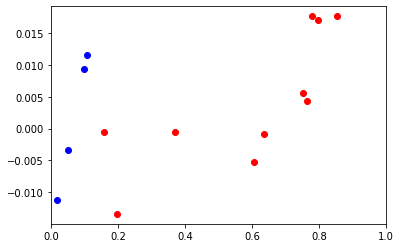

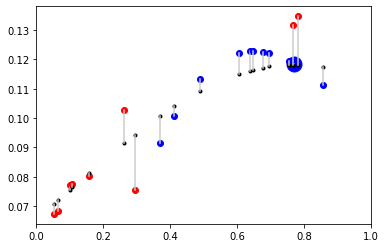

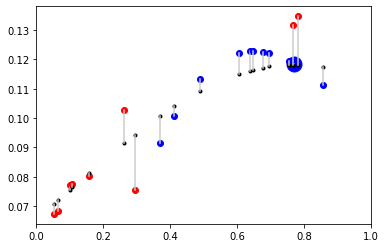

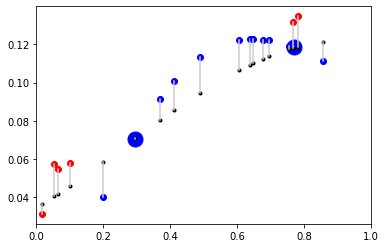

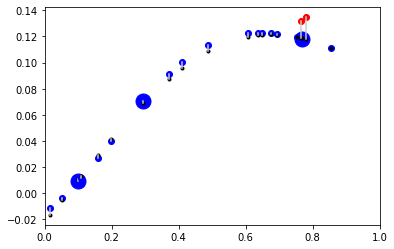

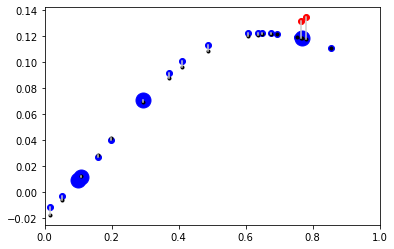

In [277]:
confirmed_matches = [] # these are the points that will be used for training
queried_points = [] # store which points we have queried

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n_its = 5 # do his many iterations
    matches = closest_match(observed_1,observed_2,confirmed_matches,queried_points,frag_1,max_rt = 0.02,predictions = None)
    truth = assess_matches(matches,data_1_idx,data_2_idx)
    plot_match(observed_1,observed_2,frag_1,matches,confirmed_matches,relative=True,predictions = None,truth=truth)


    for it in range(n_its):    
        # pick a point to query randomly -- here is where we'd do some smart choice. Pick something we didn't pick before
        unqueried = set(range(n_data)) - set(queried_points)
        new_match = query(data_1_idx,data_2_idx,np.random.choice(list(unqueried)),frag_1)
        if new_match is not None and new_match not in confirmed_matches:
            confirmed_matches.append(new_match)
        pred_mu = fit_and_predict(observed_1,observed_2,confirmed_matches,main_K)
        matches = closest_match(observed_1,observed_2,confirmed_matches,queried_points,frag_1,max_rt = 0.02,predictions = pred_mu)
        truth = assess_matches(matches,data_1_idx,data_2_idx)
        plot_match(observed_1,observed_2,frag_1,matches,confirmed_matches,relative=True,predictions = pred_mu,truth=truth)